#### SVM from scratch - Credit default



- [Lab 1: Setting Up ](#Data-Uploading)
- [Lab 2: SVM from Scratch](#SVM-from-Scratch)
- [Lab 3: Sklearn](#Sklearn-SVC)


## Data Uploading 

In [82]:
from sklearn.metrics import classification_report
from itertools import combinations_with_replacement
import numpy as np
import math
import sys

import numpy as np
from sklearn import datasets

import numpy as np
import cvxopt

import pandas as pd

# Hide cvxopt output
cvxopt.solvers.options['show_progress'] = False


# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['student2'] = df.student.factorize()[0]
df['default2'] = df.default.factorize()[0]



# removing zero LTI 
df = df[df['LTI']!= 0]

df = df[['balance','income', 'Age', 'LTI','Months Delayed', 'student2','default2']]



df[df['default2'] == 0] = df[df['default2'] == 0] - 1

#df[df['default2'] == 1] = df[df['default2'] == 1] + 1
df.head(3)

,balance,income,Age,LTI,Months Delayed,student2,default2
0,728.526495,44360.625074,49.0,-0.983555,-1,-1,-1
1,816.180407,12105.134700,24.0,-0.932499,-1,0,-1
2,1072.549164,31766.138947,38.0,-0.966206,-1,-1,-1


In [16]:



def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    return X[index], y[index]

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy


def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    L2_norm = np.atleast_1d(np.linalg.norm(X, order, axis))
    L2_norm[L2_norm == 0] = 1
    return X / np.expand_dims(L2_norm, axis)



def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test


 











In [83]:
dataset = df[0:1000].values


# Split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# split labels and datas
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(int(len(dataset))):
        rowX = dataset[i, 0:-1].astype('float32')  #/max_num_X # Normalized X
        rowy = dataset[i, -1]
        dataX.append(rowX)
        dataY.append(rowy)
    return normalize(np.asarray(dataX)), np.asarray(dataY)

X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)

## SVM from Scratch

## SVM from Scratch : Using Soft Margin SVM, and Quadratic Programming with Python and CVXOPT 

### Referenced:  https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/

In [17]:

# creating soft margin SVM and quadratic programing


def linear_kernel(**kwargs):
    def f(x1, x2):
        return np.inner(x1, x2)
    return f


def polynomial_kernel(power, coef, **kwargs):
    def f(x1, x2):
        return (np.inner(x1, x2) + coef)**power
    return f


def radical_kernel(gamma, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)
    return f

class SupportVectorMachine_scratch(object):
    """The Support Vector Machine classifier.
    Uses cvxopt to solve the quadratic optimization problem.

    Parameters:
    -----------
    C: float
        Penalty term.
    kernel: function
        Kernel function. Can be either polynomial, rbf or linear.
    power: int
        The degree of the polynomial kernel. Will be ignored by the other
        kernel functions.
    gamma: float
        Used in the rbf kernel function.
    coef: float
        Bias term used in the polynomial kernel function.
    """
    def __init__(self, C=1, kernel=radical_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.langrange_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y):

        nth_samples, nth_features = np.shape(X)

        # Set gamma to 1/nth_features by default
        if not self.gamma:
            self.gamma = 1 / nth_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        # Calculate kernel matrix
        kernel_matrix = np.zeros((nth_samples, nth_samples))
        for i in range(nth_samples):
            for j in range(nth_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])

        # Define the quadratic optimization problem
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(nth_samples) * -1)
        A = cvxopt.matrix(y, (1, nth_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if not self.C:
            G = cvxopt.matrix(np.identity(nth_samples) * -1)
            h = cvxopt.matrix(np.zeros(nth_samples))
        else:
            G_max = np.identity(nth_samples) * -1
            G_min = np.identity(nth_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(nth_samples))
            h_min = cvxopt.matrix(np.ones(nth_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))

        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lagr_mult = np.ravel(minimization['x'])

        # Extract support vectors
        # Get indexes of non-zero lagr. multipiers
        index = lagr_mult > 1e-7
        # Get the corresponding lagr. multipliers
        self.langrange_multipliers = lagr_mult[index]
        # Get the samples that will act as support vectors
        self.support_vectors = X[index]
        # Get the corresponding labels
        self.support_vector_labels = y[index]

        # Calculate intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.langrange_multipliers)):
            self.intercept -= self.langrange_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.langrange_multipliers)):
                prediction += self.langrange_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)



In [84]:
clf = SupportVectorMachine(kernel=rbf_kernel, gamma= 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)


print(classification_report(y_test, y_pred))



Accuracy: 0.956
              precision    recall  f1-score   support

        -1.0       0.96      1.00      0.98       239
         1.0       0.00      0.00      0.00        11

    accuracy                           0.96       250
   macro avg       0.48      0.50      0.49       250
weighted avg       0.91      0.96      0.93       250



/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


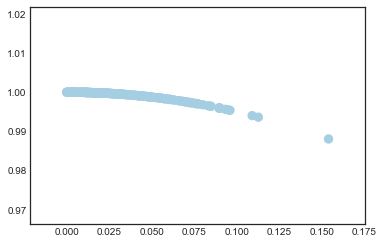

In [86]:
plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_pred, cmap=plt.cm.Paired)

# Sklearn SVC

In [76]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

%matplotlib inline
plt.style.use('seaborn-white')


dataset = df.values


# Split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# split labels and datas
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(int(len(dataset))):
        rowX = dataset[i, 0:-1].astype('float32')  #/max_num_X # Normalized X
        rowy = dataset[i, -1]
        dataX.append(rowX)
        dataY.append(rowy)
    return normalize(np.asarray(dataX)), np.asarray(dataY)

X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)

In [ ]:
# Set the parameters by cross-validation
#tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
#                     'gamma': [0.5, 1,2,3,4]}]
#clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
#clf.fit(X_train, y_train)
#clf.cv_results_


Accuracy: 0.80099040544723
              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89      7764
         2.0       0.00      0.00      0.00      1929

    accuracy                           0.80      9693
   macro avg       0.40      0.50      0.44      9693
weighted avg       0.64      0.80      0.71      9693



/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


confusion matrix: True/Prediction True       -1.0   2.0
Predicted            
-1.0       7764  1929
 2.0          0     0


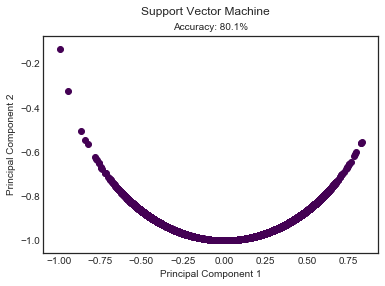

In [80]:
# More flexible model
svm = SVC(C=1, kernel='rbf', gamma=4)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm.T, index=svm.classes_, columns=svm.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('confusion matrix: True/Prediction::',cm_df)



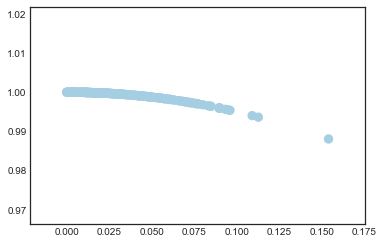

In [88]:
plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_pred, cmap=plt.cm.Paired)